In [18]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares

%matplotlib inline

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

In [15]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

In [578]:
def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index

In [490]:
def gauss(x, a, x0, sigma, b):
    return a*exp(-(x-x0)**2/(2*sigma**2))+b


def residuals(p, x, y):
    a, m, s, b = p
    y_fit = gauss(x, a, m, s, b)
    
    err = y - y_fit
    return err
    

In [585]:
def show_fit_gaussians(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
    indices = t_by_filter.groups.indices
    max_i = get_max_index(t_by_filter["flux"])
    mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        n = len(x)
        sigma = np.std(y)
        
      
        popt, pcov = curve_fit(gauss, x, y, p0=[1, mean_date, sigma, 1])
        plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])
        
        X = np.arange(0,max_date-min_date,1)
        
        plt.plot(X, gauss(X, *popt), color=colors[data[0]["bandpass"]])
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
        
        
    plt.show()

In [591]:
curves = [554000,   20003,  362011,   69015,  393015,  367516,  161020,  275024,
  254525,  488529,  353043,  323044,  275045,  427057,  334559,  237060,
  152584,   96086,  378589,  528591,  530591,  499597,  364100,  205609,
  238624,  171628,  215129,  548130,  508136,  275139,  282642,  489662,
  328663,  300671,  603671,  252672,  162173,  563183,  199187,  320194,
  589709,  181218,  354226,  321730,  375231,  371244,  588754,  169755,
  100761,  102262,  409763,  452764,  491269,  585770,  320271,  391771,
  307774,  452780,  103782,  450288,  159790,  277301,  270321,   84323,
  305823,  560323,  152326,  447832,  146839,  145345,  238345,   69346,
   86347,  231850,   72360,  536862,  201863,  220368,  437374,  157377,
  295384,  606385,  168391,  454891,  150894,  152407,    8910,  527422,
  330434,  532940,  607447,  563958,  550462,  527464,  206968,  275472,
  387472,  541474,  352982,  354483,  538486,  127487,  395488,   51991,
   51997,]
lcs = []
for c in curves:

    lienObj = glob.glob("/datadec/cppm/jpreyes/mpi_tests/multicolour_set/"+str(c)+".dat")


    for oj in lienObj:
        table = ascii.read(oj)
        lcs.append(table)
        break

#show_multi_filter_light_curve(lcs[0], snls_colors)

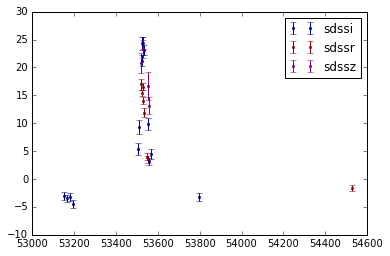

In [607]:
lc = lcs[90]
show_multi_filter_light_curve(lc, snls_colors)

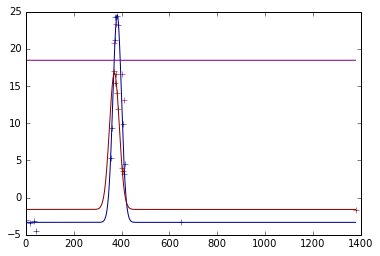

In [608]:
show_fit_gaussians(lc, snls_colors)

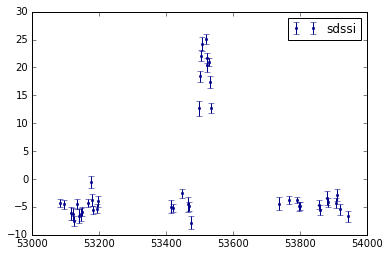

In [581]:
lc = lcs[0]
mask = lc["bandpass"] == "sdssi"
lc_i = lc[mask]
show_multi_filter_light_curve(lc_i, snls_colors)

In [582]:
t_by_filter = lc.group_by("bandpass")
min_date = min(lc["mjd"])
max_date = max(lc["mjd"])

indices = t_by_filter.groups.indices
max_i = get_max_index(t_by_filter["flux"])
print max_i

31


In [583]:
from sklearn.preprocessing import normalize
from scipy.optimize import leastsq

x = lc_i["mjd"]-min(lc["mjd"])
y = lc_i["flux"]
y_error = lc_i["flux_error"]
#x = normalize(x)[0]
n = len(x)
mean = sum(x*y)/n
#sigma = sum((x-435)**2)/n
sigma = np.std(y)

In [515]:
print sigma

10.481611015


In [516]:
popt, pcov = curve_fit(gauss, x, y, sigma=y_error, p0=[1, 424, sigma, 1], maxfev=2000)

In [517]:
pars = least_squares(residuals, x0=[1, 424, sigma, 1], args=(x,y), max_nfev=10000)

In [518]:
for i, j in zip(x, y):
    print j-gauss(i, *pars.x)
    print j-gauss(i, *popt)
    print "===="

0.544452895394
0.427775652171
====
0.357234229317
0.240556986095
====
-1.28976083828
-1.4064380815
====
-1.42903543545
-1.54571267867
====
-2.6786639793
-2.79534122252
====
0.379333724251
0.262656481029
====
-1.73787475658
-1.85455199981
====
-1.43101240231
-1.54768964553
====
-0.984266052971
-1.10094329619
====
0.626245249977
0.509568006755
====
4.30039100813
4.18371376491
====
1.12389253544
1.00721529222
====
-0.689098129997
-0.805775373219
====
-0.414577732811
-0.531254976033
====
0.89502262043
0.778345377208
====
-0.0473457966072
-0.164023530426
====
-0.317763363754
-0.434442272535
====
2.30770180823
2.18962767967
====
-0.155656507899
-0.305878507965
====
-0.846678019151
-1.00998664829
====
-4.41541528599
-4.59975980766
====
-0.885055107773
-1.03241193343
====
0.613563765727
0.522274378391
====
1.43511859926
1.38164856898
====
1.16673987193
1.1394770718
====
-0.386582225378
-0.470487325034
====
-3.19365076795
-3.35960458383
====
-1.27335830668
-1.46262585211
====
1.40216358807
1.11

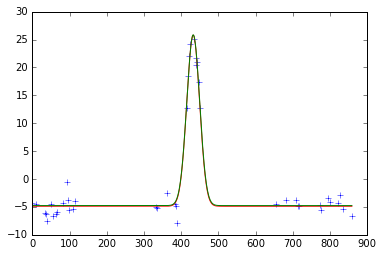

In [519]:
plt.plot(x, y, 'b+')
X = np.arange(min(x), max(x),1)
plt.plot(X, gauss(X, *pars.x), color="red")
plt.plot(X, gauss(X, *popt), color="green")
#plt.xlim(xmin=0, xmax=500)
#plt.ylim(ymin=-200, ymax=200)
plt.show()

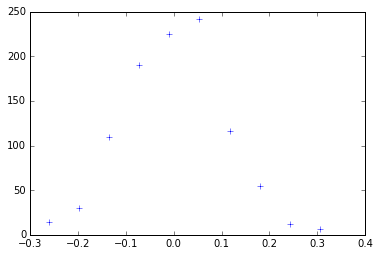

In [520]:
x0, sigma = 0, 0.1
y, xe  = np.histogram(np.random.normal(x0, sigma, 1000))
x = .5 * (xe[:-1] + xe[1:])

plt.plot(x,y, "b+")

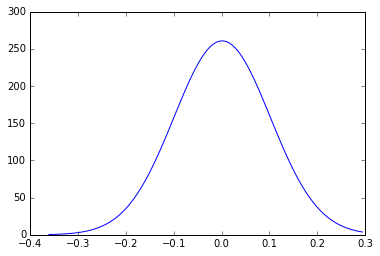

In [71]:
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=p0)
x_fine = np.linspace(xe[0], xe[-1], 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'b-')